# MiniGrid settings

## Basic Jupyter Setting

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

## Initial set-up

Import libraries and classes:

In [6]:
# Imports
import time
import io
import os
import glob
import torch
import base64
# import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt
from random import randint 

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

Define the video function:

In [ ]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_animation(experiment):
    giflist = glob.glob('animation/*.gif')
    if len(giflist) > 0:
        matching = [s for s in giflist if experiment in s]
        gif_path = matching[0]
        b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
        display.display(HTML(f'<img src="data:image/gif;base64,{b64}" height="400" />'))
    else:
        print("Could not find animation")

Define the rendering wrappers:

In [ ]:
from gym.wrappers import Monitor

# Define wrapper for CNN Policy
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

def gen_wrapped_env_cnn(env_name):
    return wrap_env(ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name))))

Render an environment image:

In [ ]:
from random import randint
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-Empty-16x16-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'BreakoutNoFrameskip-v4'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
#random_action = eval_env.action_space.sample()
#new_obs, reward, done, info = eval_env.step(random_action)

before_img = eval_env.render('rgb_array')

plt.figure(figsize = (4.,4.))
plt.imshow(before_img);

# Meta-RIMs learning

## Define the environments

### Import libraries

In [7]:
import time
import io
import os
import glob
import base64
import datetime
import torch
import torch_ac
import tensorboardX
import sys
import utils
from model import ACModel
from torch_ac.utils import DictList, ParallelEnv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

### Helper functions

In [8]:
def make_envs(env_id, procs, seed=None):
    envs = []
    for i in range(procs):
        if seed:
            e = utils.make_env(env_id, seed + 10000 * i)
        else:
            e = utils.make_env(env_id)
        envs.append(e)
    env = ParallelEnv(envs)
    return env

def sample_tasks(n_tasks):
    tasks_list = []
    for i in range(n_tasks):
        random_data = os.urandom(4)
        seed = int.from_bytes(random_data, byteorder="big")
        tasks_list.append(seed)
    return tasks_list

def env_snapshot(env:ParallelEnv):
    im_list = []
    for e in env.envs:
        #print(type(e.render('rgb_array')))
        #e.reset()
        im_list.append(e.render('rgb_array'))

    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, im_list):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

def set_freeze_status(model, params, freeze=True):
    for name, param in model.named_parameters():
        if any(ext in name for ext in params):
            param.requires_grad = False if freeze else True
            #param.grad = None if freeze else param.grad

# Function to concatenate two tasks rollout exps dictionaries
def cat_exps(exps_1, exps_2):
    exp_out = {}
    for (k,v), (k2,v2) in zip(exps_1.items(), exps_2.items()):
        if k == 'obs':
            obs = k
            exp_out[obs] = {}
            for (k,v), (k2,v2) in zip(exps_1.obs.items(), exps_2.obs.items()):
                exp_out[obs][k] = torch.cat((v, v2), 0)
        else:
            exp_out[k] = torch.cat((v, v2), 0)
    return exp_out

# Function to concatenate two tasks rollout logs dictionaries
def cat_logs(logs_1, logs_2):
    logs_out = {}
    for (k,v), (k2,v2) in zip(logs_1.items(), logs_2.items()):
        logs_out[k] = v + v2
    return logs_out

def change_multienv_seed(env, seed):
    for i, e in enumerate(env.envs):
        e.seed(seed + 10000 * i)
        e.reset()
    return env
        
def sample_tasks_experiences(agent, tasks):
    seed_list = tasks['seed_list']
    exps_batch = []
    logs1_batch = []
    for seed in seed_list:
        agent.env = change_multienv_seed(agent.env, seed)
        #agent.env = make_envs(env_id, procs, seed)
        exps, logs1 = agent.collect_experiences() 
        exps_batch.append(exps)
        logs1_batch.append(logs1)
    return exps_batch, logs1_batch

# Function to collect and concatenate all tasks rollout exps dictionaries
def collect_tasks_meta_experiences(agent, tasks):
    seed_list = tasks['seed_list']
    for i, seed in enumerate(seed_list):
        #agent.env = make_envs(env_id, procs, seed)
        agent.env = change_multienv_seed(agent.env, seed)
        exps, logs1 = agent.collect_experiences()
        concat_exps = exps if i==0 else cat_exps(concat_exps, exps)
        concat_exps = DictList(concat_exps)
        concat_exps.obs = DictList(concat_exps.obs)
        concat_logs1 = logs1 if i==0 else cat_logs(concat_logs1, logs1)
    return concat_exps, concat_logs1

### Render Parallel environment snapshot

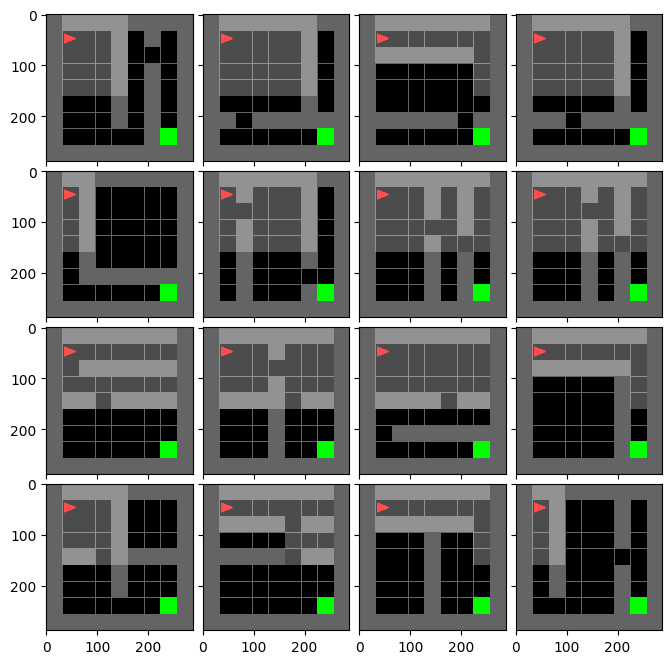

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

procs = 16
max_tasks = 20
seed_list = range(procs * max_tasks, (procs + 1) * max_tasks)

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-LavaCrossingS9N2-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'

seed = 1
env = make_envs(env_id, procs, seed)
obs = env.reset()

im_list = []
for e in env.envs:
    #print(type(e.render('rgb_array')))
    #e.reset()
    im_list.append(e.render('rgb_array'))

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

#plt.show()


## Configuration

### Load parameters

In [10]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#model = 'MiniGrid-WallGapS6-v0_alt_MiniGrid-DoorKey-6x6-v0_metaRIMs_6_4_proc_16_Adam_inputvalue_64_inputheads_1_batch_256_nxt_MiniGrid-RedBlueDoors-6x6-v0_1M_mid'
model = 'test_metarims_6_4_wallgap_doorkey_reshaped'
processes = 16
frames = 1e6

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'early_stop':True,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':32, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'use_rim':True, # action = 'store_true'
'meta_learn':True,
'reshape_reward':True
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# RIM specific hyperparameters
if args.use_rim:
    args.num_units = 6
    args.k = 4
    args.input_heads = 1

if args.meta_learn:
    args.lr_alpha= args.lr
    args.lr_beta= args.lr
    args.inner_recurrence= 8
    args.outer_recurrence= 32 # 4x inner_recurrence
    args.num_tasks = 2
    args.inner_params= ['image_conv', 'i2h', 'h2h', 'actor'] # params to be updated in inner loop
    args.outer_params = ['query', 'key', 'value', 'comm', 'critic'] # params to be updated in outer loop

### Initial settings

In [11]:
# Set run dir

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-WallGapS6-v0', 'model': 'test_metarims_6_4_wallgap_doorkey_reshaped', 'early_stop': True, 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'meta_learn': True, 'reshape_reward': True, 'mem': True, 'num_units': 6, 'k': 4, 'input_heads': 1, 'lr_alpha': 0.0007, 'lr_beta': 0.0007, 'inner_recurrence': 8, 'outer_recurrence': 32, 'num_tasks': 2, 'inner_params': ['image_conv', 'i2h', 'h2h', 'actor'], 'outer_params': ['query', 'key', 'value', 'comm', 'critic']}

Device: cpu



### Load environments, model, algo and prepare training settings

In [12]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, reshape_reward)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (memory_rnn): RIMCell(
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (rnn): GroupLSTMCell(
      (i2h): GroupLinearLayer()
      (h2h): GroupLinearLayer()
    )
    (query): GroupLinearLayer()
    (query_): GroupLinearLayer()
    (key_): GroupLinearLayer()
    (value_): GroupLinearLayer()
    (comm_attention_output): GroupLinearLayer()
    (comm_dropout): Dropout(p=0.1, inplace=False)
    (input_dropout): Dropout(p=0.1, inplace=False)
  )
  (actor): Sequentia

## Meta-training

### Set initial parameters

In [13]:
# meta-learn initializacion

# delete param_groups after it has been created
for i in range(len(algo.optimizer.param_groups)):
    del algo.optimizer.param_groups[0]

# Re-create separate param_groups for different inner and outer loop optimizer lr

# inner loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.image_conv.parameters(), 
    *acmodel.memory_rnn.rnn.parameters(), 
    *acmodel.actor.parameters()], 'lr': args.lr_alpha})

# outer loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.critic.parameters(), 
    *acmodel.memory_rnn.key.parameters(),
    *acmodel.memory_rnn.key_.parameters(),
    *acmodel.memory_rnn.query.parameters(),
    *acmodel.memory_rnn.query_.parameters(),
    *acmodel.memory_rnn.value.parameters(),
    *acmodel.memory_rnn.value_.parameters(),
    *acmodel.memory_rnn.comm_attention_output.parameters()
    ], 'lr': args.lr_beta})

## Training 

In [14]:
## Training

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average settings for early stop
threshold = 0.9
window = 10
rreturn_total = 0
i = 0

# run just once to have initial grads in all parameters and avoid backward error on first pass
exps, _ = algo.collect_experiences()
algo.update_parameters(exps)

while num_frames < args.frames: # STEP 2

    update_start_time = time.time()

    # Sample batch of tasks: STEP 3
    tasks_batch = sample_tasks(n_tasks=args.num_tasks)

    for n, task in enumerate(tasks_batch):

        algo.env = change_multienv_seed(algo.env, seed=task)
        # Sample pre-trajectories from each task: STEP 4
        pre_exps, pre_logs1 = algo.collect_experiences()
         # Unfreeze inner loop params,so grads can get updated in the inner loop
        set_freeze_status(algo.acmodel, args.inner_params, freeze=False)
        # Freeze outer loop parameters, so grads do not get updated in the inner loop
        set_freeze_status(algo.acmodel, args.outer_params, freeze=True)
        # set inner RIM recurence
        algo.recurrence = args.inner_recurrence
        # Update parameters: STEP 6
        algo.update_parameters(pre_exps)
        # Sample post-trajectories t_i from tasks T_i: STEP 7
        post_exps, post_logs1 = algo.collect_experiences()
        # Concatenate to get D_meta: STEP 8
        meta_exps = post_exps if n==0 else cat_exps(meta_exps, post_exps)
        meta_exps = DictList(meta_exps)
        meta_exps.obs = DictList(meta_exps.obs)
        meta_logs1 = post_logs1 if n==0 else cat_logs(meta_logs1, post_logs1)

    # Unfreeze outer loop params, so so grads can get updated in the outer loop
    set_freeze_status(algo.acmodel, args.outer_params, freeze=False)
    # Freeze inner loop params, so grads do not get updated in the outer loop
    set_freeze_status(algo.acmodel, args.inner_params, freeze=True)   
    
    # set outer RIM recurence
    algo.recurrence = args.outer_recurrence

    # Update parameters while keeping inner parametes (module and policy) frozen: STEP 9
    meta_logs2 = algo.update_parameters(meta_exps)

    meta_logs = {**meta_logs1, **meta_logs2}
    update_end_time = time.time()

    num_frames += meta_logs["num_frames"]
    update += 1    
    
    # Print logs

    if update % args.log_interval == 0:

        fps = meta_logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(meta_logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(meta_logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(meta_logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        if args.early_stop:
            #rreturn_total +=rreturn_per_episode['mean']
            rreturn_total +=return_per_episode['mean']
            i+=1
            if i >= window:
                rreturn_mavg = rreturn_total / i
                if rreturn_mavg >= threshold:
                    break
                else:
                    i = 0
                    rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        #header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        #data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()       
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [meta_logs["entropy"], meta_logs["value"], meta_logs["policy_loss"], meta_logs["value_loss"], meta_logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)       

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")
# STEP 10

print("Number of frames: ", num_frames)

MiniGrid-WallGapS6-v0
U 1 | F 004096 | FPS 0431 | D 14 | rR:μσmM 0.08 0.18 0.00 0.65 | F:μσmM 141.1 37.5 56.0 272.0 | H 1.897 | V -1.659 | pL 28.662 | vL 966.231 | ∇ 1.495
MiniGrid-WallGapS6-v0
U 2 | F 008192 | FPS 0438 | D 24 | rR:μσmM 0.03 0.17 0.00 0.96 | F:μσmM 146.5 36.9 7.0 256.0 | H 1.882 | V -3.261 | pL 27.001 | vL 856.741 | ∇ 2.538
MiniGrid-WallGapS6-v0
U 3 | F 012288 | FPS 0414 | D 34 | rR:μσmM 0.08 0.21 0.00 0.93 | F:μσmM 141.0 41.1 12.0 256.0 | H 1.873 | V -4.361 | pL 23.990 | vL 699.849 | ∇ 2.983
MiniGrid-WallGapS6-v0
U 4 | F 016384 | FPS 0411 | D 44 | rR:μσmM 0.10 0.22 0.00 0.74 | F:μσmM 131.5 29.8 42.0 165.0 | H 1.799 | V -5.281 | pL 26.599 | vL 845.094 | ∇ 7.289
MiniGrid-WallGapS6-v0
U 5 | F 020480 | FPS 0444 | D 53 | rR:μσmM 0.10 0.21 0.00 0.87 | F:μσmM 138.7 41.0 21.0 256.0 | H 1.854 | V -5.939 | pL 25.651 | vL 794.389 | ∇ 2.910
MiniGrid-WallGapS6-v0
U 6 | F 024576 | FPS 0380 | D 64 | rR:μσmM 0.03 0.13 0.00 0.76 | F:μσmM 147.3 33.5 39.0 256.0 | H 1.816 | V -6.345 | pL

## Evaluation

### Load parameters

In [15]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
env_id = 'MiniGrid-WallGapS6-v0'

## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-WallGapS6-v0', 'model': 'test_metarims_6_4_wallgap_doorkey_reshaped', 'early_stop': True, 'seed': 2, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'meta_learn': True, 'reshape_reward': True, 'mem': True, 'num_units': 6, 'k': 4, 'input_heads': 1, 'lr_alpha': 0.0007, 'lr_beta': 0.0007, 'inner_recurrence': 8, 'outer_recurrence': 32, 'num_tasks': 2, 'inner_params': ['image_conv', 'i2h', 'h2h', 'actor'], 'outer_params': ['query', 'key', 'value', 'comm', 'critic'], 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



### Set environments, agent and logs, Run agent and print results

In [16]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

# print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
#       .format(num_frames, fps, duration,
#               *return_per_episode.values(),
#               *num_frames_per_episode.values()))

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-WallGapS6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 1074.0 | FPS 2927 | D 0.0 | R:μσmM 0.93 0.03 0.84 0.98 | F:μσmM 10.9 5.1 3.0 25.0


## Visualization

### Load parameters

In [ ]:
import array2gif
from pathlib import Path
import numpy

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':args.model,
'seed':15,
'shift':0,
'argmax':False,
'pause':0.1,
'gif':args.model,
'episodes':5,
# Model Parameters
'use_rim':args.use_rim,
'num_units':args.num_units,
'k':args.k
}

args = DictList(args)
print(args)

### Set environment, agent and logs

In [ ]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environment

env = utils.make_env(args.env, args.seed)
for _ in range(args.shift):
    env.reset()
print("Environment loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax, use_rim = args.use_rim, num_units = args.num_units, k = args.k)

print("Agent loaded\n")

### Make animation

In [ ]:
%%capture
# Run the agent

if args.gif:
   from array2gif import write_gif
   frames = []

# Create a window to view the environment
env.render('human')

for episode in range(args.episodes):
    obs = env.reset()
    done2 = False
    while True:
        env.render('human')
        if args.gif:
            frames.append(numpy.moveaxis(env.render("rgb_array"), 2, 0))
            

        action = agent.get_action(obs)
        obs, reward, done, _ = env.step(action)
        agent.analyze_feedback(reward, done)
        
        if done or env.window.closed:
            if episode == 4:
                done2 = True
            break
    if done2 == True:
        env.close()
        break
    #if env.window.closed:
    #    break
print('doneeee')
if args.gif:
    print("Saving gif... ", end="")
    utils.create_folders_if_necessary("./animation")
    #Path("./animation").mkdir(parents=True, exist_ok=True)
    write_gif(numpy.array(frames), "./animation/"+args.gif+".gif")
    print("Done.")

In [ ]:
show_animation(args.model)

### Make video

In [ ]:
test_env = wrap_env(env)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
    action = agent.get_action(observation)
    observation, reward, done, info = test_env.step(action)
    episode_reward += reward
    episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

# Continue learning on 2nd environment

## Configuration

### Set general parameters

In [17]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id_1 = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'

#model = 'MiniGrid-WallGapS6-v0_alt_MiniGrid-DoorKey-6x6-v0_meta_RIMs_6_4_proc_16_RMSProp_nxt_MiniGrid-RedBlueDoors-6x6-v0_end'

add_frames = 2e6
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'early_stop':True,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':32, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'use_rim':True, # action = 'store_true'
'meta_learn':True,
'reshape_reward':True
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# RIM specific hyperparameters
if args.use_rim:
    args.num_units = 6
    args.k = 4
    args.input_heads = 1

if args.meta_learn:
    args.lr_alpha= args.lr
    args.lr_beta= args.lr
    args.inner_recurrence= 8
    args.outer_recurrence= 32 # 4x inner_recurrence
    args.num_tasks = 2
    args.inner_params= ['image_conv', 'i2h', 'h2h', 'actor'] # params to be updated in inner loop
    args.outer_params = ['query', 'key', 'value', 'comm', 'critic'] # params to be updated in outer loop

### Load previous loggers and settings

In [18]:
# Set run dir

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_metarims_6_4_wallgap_doorkey_reshaped', 'early_stop': True, 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 3000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'meta_learn': True, 'reshape_reward': True, 'mem': True, 'num_units': 6, 'k': 4, 'input_heads': 1, 'lr_alpha': 0.0007, 'lr_beta': 0.0007, 'inner_recurrence': 8, 'outer_recurrence': 32, 'num_tasks': 2, 'inner_params': ['image_conv', 'i2h', 'h2h', 'actor'], 'outer_params': ['query', 'key', 'value', 'comm', 'critic']}

Device: cpu



### Load existing environments, model and training status

In [20]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, reshape_reward)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

# delete param_groups after it has been created
for i in range(len(algo.optimizer.param_groups)):
    del algo.optimizer.param_groups[0]

# Re-create separate param_groups for different inner and outer loop optimizer lr

# inner loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.image_conv.parameters(), 
    *acmodel.memory_rnn.rnn.parameters(), 
    *acmodel.actor.parameters()], 'lr': args.lr_alpha})

# outer loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.critic.parameters(), 
    *acmodel.memory_rnn.key.parameters(),
    *acmodel.memory_rnn.key_.parameters(),
    *acmodel.memory_rnn.query.parameters(),
    *acmodel.memory_rnn.query_.parameters(),
    *acmodel.memory_rnn.value.parameters(),
    *acmodel.memory_rnn.value_.parameters(),
    *acmodel.memory_rnn.comm_attention_output.parameters()
    ], 'lr': args.lr_beta})

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (memory_rnn): RIMCell(
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (rnn): GroupLSTMCell(
      (i2h): GroupLinearLayer()
      (h2h): GroupLinearLayer()
    )
    (query): GroupLinearLayer()
    (query_): GroupLinearLayer()
    (key_): GroupLinearLayer()
    (value_): GroupLinearLayer()
    (comm_attention_output): GroupLinearLayer()
    (comm_dropout): Dropout(p=0.1, inplace=False)
    (input_dropout): Dropout(p=0.1, inplace=False)
  )
  (actor): Sequentia

## Continue training

In [21]:
## Training

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average settings for early stop
threshold = 0.9
window = 10
rreturn_total = 0
i = 0

# run just once to have initial grads in all parameters and avoid backward error on first pass
exps, _ = algo.collect_experiences()
algo.update_parameters(exps)

while num_frames < args.frames: # STEP 2

    update_start_time = time.time()

    # Sample batch of tasks: STEP 3
    tasks_batch = sample_tasks(n_tasks=args.num_tasks)

    for n, task in enumerate(tasks_batch):

        algo.env = change_multienv_seed(algo.env, seed=task)
        # Sample pre-trajectories from each task: STEP 4
        pre_exps, pre_logs1 = algo.collect_experiences()
         # Unfreeze inner loop params,so grads can get updated in the inner loop
        set_freeze_status(algo.acmodel, args.inner_params, freeze=False)
        # Freeze outer loop parameters, so grads do not get updated in the inner loop
        set_freeze_status(algo.acmodel, args.outer_params, freeze=True)
        # set inner RIM recurence
        algo.recurrence = args.inner_recurrence
        # Update parameters: STEP 6
        algo.update_parameters(pre_exps)
        # Sample post-trajectories t_i from tasks T_i: STEP 7
        post_exps, post_logs1 = algo.collect_experiences()
        # Concatenate to get D_meta: STEP 8
        meta_exps = post_exps if n==0 else cat_exps(meta_exps, post_exps)
        meta_exps = DictList(meta_exps)
        meta_exps.obs = DictList(meta_exps.obs)
        meta_logs1 = post_logs1 if n==0 else cat_logs(meta_logs1, post_logs1)

    # Unfreeze outer loop params, so so grads can get updated in the outer loop
    set_freeze_status(algo.acmodel, args.outer_params, freeze=False)
    # Freeze inner loop params, so grads do not get updated in the outer loop
    set_freeze_status(algo.acmodel, args.inner_params, freeze=True)   
    
    # set outer RIM recurence
    algo.recurrence = args.outer_recurrence

    # Update parameters while keeping inner parametes (module and policy) frozen: STEP 9
    meta_logs2 = algo.update_parameters(meta_exps)

    meta_logs = {**meta_logs1, **meta_logs2}
    update_end_time = time.time()

    num_frames += meta_logs["num_frames"]
    update += 1    
    
    # Print logs

    if update % args.log_interval == 0:
        
        fps = meta_logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(meta_logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(meta_logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(meta_logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        if args.early_stop:
            #rreturn_total +=rreturn_per_episode['mean']
            rreturn_total +=return_per_episode['mean']
            i+=1
            if i >= window:
                rreturn_mavg = rreturn_total / i
                if rreturn_mavg >= threshold:
                    break
                else:
                    i = 0
                    rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        #header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        #data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()       
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [meta_logs["entropy"], meta_logs["value"], meta_logs["policy_loss"], meta_logs["value_loss"], meta_logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)       

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")
# STEP 10

print("Number of frames: ", num_frames)

U 201 | F 823296 | FPS 0429 | D 15 | rR:μσmM 0.05 0.18 0.00 0.88 | F:μσmM 332.9 86.8 0.0 360.0 | H 1.307 | V -18.971 | pL 13.998 | vL 376.551 | ∇ 23.387
U 202 | F 827392 | FPS 0389 | D 25 | rR:μσmM 0.06 0.20 0.00 0.88 | F:μσmM 339.0 68.1 49.0 360.0 | H 1.295 | V -21.627 | pL 27.877 | vL 787.895 | ∇ 8.836
U 203 | F 831488 | FPS 0420 | D 35 | rR:μσmM 0.10 0.22 0.00 0.81 | F:μσmM 329.9 74.6 74.0 360.0 | H 1.408 | V -24.408 | pL 24.848 | vL 681.629 | ∇ 6.672
U 204 | F 835584 | FPS 0465 | D 44 | rR:μσmM 0.15 0.27 0.00 0.86 | F:μσmM 310.8 94.3 56.0 360.0 | H 1.581 | V -27.299 | pL 23.067 | vL 615.769 | ∇ 8.330
U 205 | F 839680 | FPS 0474 | D 52 | rR:μσmM 0.21 0.28 0.00 0.80 | F:μσmM 292.8 95.3 81.0 360.0 | H 1.576 | V -29.294 | pL 18.438 | vL 508.202 | ∇ 16.205
U 206 | F 843776 | FPS 0483 | D 61 | rR:μσmM 0.09 0.18 0.00 0.70 | F:μσmM 333.4 59.3 120.0 360.0 | H 1.567 | V -29.910 | pL 15.469 | vL 454.472 | ∇ 23.183
U 207 | F 847872 | FPS 0484 | D 69 | rR:μσmM 0.10 0.25 0.00 0.91 | F:μσmM 326.3

## Evaluate environment

### Load parameters

In [22]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id_1 = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'

args.model = 'test_metarims_6_4_wallgap_doorkey_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_metarims_6_4_wallgap_doorkey_reshaped', 'early_stop': True, 'seed': 2, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 3000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'meta_learn': True, 'reshape_reward': True, 'mem': True, 'num_units': 6, 'k': 4, 'input_heads': 1, 'lr_alpha': 0.0007, 'lr_beta': 0.0007, 'inner_recurrence': 8, 'outer_recurrence': 32, 'num_tasks': 2, 'inner_params': ['image_conv', 'i2h', 'h2h', 'actor'], 'outer_params': ['query', 'key', 'value', 'comm', 'critic'], 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



### Set environments, agent and logs, Run agent and print results

In [23]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

# print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
#       .format(num_frames, fps, duration,
#               *return_per_episode.values(),
#               *num_frames_per_episode.values()))

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-DoorKey-6x6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 3238.0 | FPS 3031 | D 1.0 | R:μσmM 0.92 0.05 0.70 0.97 | F:μσmM 32.6 20.5 12.0 118.0


# Re-evaluate previous environments and test CF

### Load parameters env 1

In [24]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'

args.model = 'test_metarims_6_4_wallgap_doorkey_reshaped'
## Hyper-parameters
args.env = env_id
args.model = model
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-WallGapS6-v0', 'model': 'test_metarims_6_4_wallgap_doorkey_reshaped', 'early_stop': True, 'seed': 3, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 3000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'meta_learn': True, 'reshape_reward': True, 'mem': True, 'num_units': 6, 'k': 4, 'input_heads': 1, 'lr_alpha': 0.0007, 'lr_beta': 0.0007, 'inner_recurrence': 8, 'outer_recurrence': 32, 'num_tasks': 2, 'inner_params': ['image_conv', 'i2h', 'h2h', 'actor'], 'outer_params': ['query', 'key', 'value', 'comm', 'critic'], 'episodes': 100, 'argmax': False, 'worst_episodes_to_show': None}
Device: cpu



### Set environments, agent and logs, Run agent and print results for env 1

In [25]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

# print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
#       .format(num_frames, fps, duration,
#               *return_per_episode.values(),
#               *num_frames_per_episode.values()))

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

Env: MiniGrid-WallGapS6-v0 

Environments loaded
Agent loaded
Agent run_1 completed

Environments loaded
Agent loaded
Agent run_2 completed

Environments loaded
Agent loaded
Agent run_3 completed

F 9662.0 | FPS 3114 | D 3.0 | R:μσmM 0.35 0.41 0.00 0.99 | F:μσmM 95.2 57.8 2.0 144.0


# Continue learning on 3rd environment

In [26]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id_1 = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
env_id = 'MiniGrid-SimpleCrossingS9N2-v0'

#model = 'MiniGrid-WallGapS6-v0_alt_MiniGrid-DoorKey-6x6-v0_meta_RIMs_6_4_proc_16_RMSProp_nxt_MiniGrid-RedBlueDoors-6x6-v0_end'
model = 'test_metarims_6_4_wallgap_doorkey_crossing_reshaped'

add_frames = 2e6
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'early_stop':True,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':32, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'use_rim':True, # action = 'store_true'
'meta_learn':True,
'reshape_reward':True
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# RIM specific hyperparameters
if args.use_rim:
    args.num_units = 6
    args.k = 4
    args.input_heads = 1

if args.meta_learn:
    args.lr_alpha= args.lr
    args.lr_beta= args.lr
    args.inner_recurrence= 8
    args.outer_recurrence= 32 # 4x inner_recurrence
    args.num_tasks = 2
    args.inner_params= ['image_conv', 'i2h', 'h2h', 'actor'] # params to be updated in inner loop
    args.outer_params = ['query', 'key', 'value', 'comm', 'critic'] # params to be updated in outer loop

In [27]:
# Set run dir

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-SimpleCrossingS9N2-v0', 'model': 'test_metarims_6_4_wallgap_doorkey_crossing_reshaped', 'early_stop': True, 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 5000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'meta_learn': True, 'reshape_reward': True, 'mem': True, 'num_units': 6, 'k': 4, 'input_heads': 1, 'lr_alpha': 0.0007, 'lr_beta': 0.0007, 'inner_recurrence': 8, 'outer_recurrence': 32, 'num_tasks': 2, 'inner_params': ['image_conv', 'i2h', 'h2h', 'actor'], 'outer_params': ['query', 'key', 'value', 'comm', 'critic']}

Device: cpu



In [28]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, reshape_reward)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

# delete param_groups after it has been created
for i in range(len(algo.optimizer.param_groups)):
    del algo.optimizer.param_groups[0]

# Re-create separate param_groups for different inner and outer loop optimizer lr

# inner loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.image_conv.parameters(), 
    *acmodel.memory_rnn.rnn.parameters(), 
    *acmodel.actor.parameters()], 'lr': args.lr_alpha})

# outer loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.critic.parameters(), 
    *acmodel.memory_rnn.key.parameters(),
    *acmodel.memory_rnn.key_.parameters(),
    *acmodel.memory_rnn.query.parameters(),
    *acmodel.memory_rnn.query_.parameters(),
    *acmodel.memory_rnn.value.parameters(),
    *acmodel.memory_rnn.value_.parameters(),
    *acmodel.memory_rnn.comm_attention_output.parameters()
    ], 'lr': args.lr_beta})

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (memory_rnn): RIMCell(
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (rnn): GroupLSTMCell(
      (i2h): GroupLinearLayer()
      (h2h): GroupLinearLayer()
    )
    (query): GroupLinearLayer()
    (query_): GroupLinearLayer()
    (key_): GroupLinearLayer()
    (value_): GroupLinearLayer()
    (comm_attention_output): GroupLinearLayer()
    (comm_dropout): Dropout(p=0.1, inplace=False)
    (input_dropout): Dropout(p=0.1, inplace=False)
  )
  (actor): Sequentia

In [29]:
## Training

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average settings for early stop
threshold = 0.9
window = 10
rreturn_total = 0
i = 0

# run just once to have initial grads in all parameters and avoid backward error on first pass
exps, _ = algo.collect_experiences()
algo.update_parameters(exps)

while num_frames < args.frames: # STEP 2

    update_start_time = time.time()

    # Sample batch of tasks: STEP 3
    tasks_batch = sample_tasks(n_tasks=args.num_tasks)

    for n, task in enumerate(tasks_batch):

        algo.env = change_multienv_seed(algo.env, seed=task)
        # Sample pre-trajectories from each task: STEP 4
        pre_exps, pre_logs1 = algo.collect_experiences()
         # Unfreeze inner loop params,so grads can get updated in the inner loop
        set_freeze_status(algo.acmodel, args.inner_params, freeze=False)
        # Freeze outer loop parameters, so grads do not get updated in the inner loop
        set_freeze_status(algo.acmodel, args.outer_params, freeze=True)
        # set inner RIM recurence
        algo.recurrence = args.inner_recurrence
        # Update parameters: STEP 6
        algo.update_parameters(pre_exps)
        # Sample post-trajectories t_i from tasks T_i: STEP 7
        post_exps, post_logs1 = algo.collect_experiences()
        # Concatenate to get D_meta: STEP 8
        meta_exps = post_exps if n==0 else cat_exps(meta_exps, post_exps)
        meta_exps = DictList(meta_exps)
        meta_exps.obs = DictList(meta_exps.obs)
        meta_logs1 = post_logs1 if n==0 else cat_logs(meta_logs1, post_logs1)

    # Unfreeze outer loop params, so so grads can get updated in the outer loop
    set_freeze_status(algo.acmodel, args.outer_params, freeze=False)
    # Freeze inner loop params, so grads do not get updated in the outer loop
    set_freeze_status(algo.acmodel, args.inner_params, freeze=True)   
    
    # set outer RIM recurence
    algo.recurrence = args.outer_recurrence

    # Update parameters while keeping inner parametes (module and policy) frozen: STEP 9
    meta_logs2 = algo.update_parameters(meta_exps)

    meta_logs = {**meta_logs1, **meta_logs2}
    update_end_time = time.time()

    num_frames += meta_logs["num_frames"]
    update += 1    
    
    # Print logs

    if update % args.log_interval == 0:
        
        fps = meta_logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(meta_logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(meta_logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(meta_logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        if args.early_stop:
            #rreturn_total +=rreturn_per_episode['mean']
            rreturn_total +=return_per_episode['mean']
            i+=1
            if i >= window:
                rreturn_mavg = rreturn_total / i
                if rreturn_mavg >= threshold:
                    break
                else:
                    i = 0
                    rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        #header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        #data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()       
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [meta_logs["entropy"], meta_logs["value"], meta_logs["policy_loss"], meta_logs["value_loss"], meta_logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)       

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")
# STEP 10

print("Number of frames: ", num_frames)

U 291 | F 1191936 | FPS 0418 | D 15 | rR:μσmM 0.17 0.26 0.00 0.81 | F:μσmM 281.9 80.0 70.0 351.0 | H 1.262 | V -32.469 | pL 7.127 | vL 302.993 | ∇ 45.238
U 292 | F 1196032 | FPS 0418 | D 25 | rR:μσmM 0.20 0.29 0.00 0.77 | F:μσmM 264.5 89.0 81.0 324.0 | H 1.273 | V -38.014 | pL 16.064 | vL 405.218 | ∇ 17.448
U 293 | F 1200128 | FPS 0431 | D 34 | rR:μσmM 0.15 0.23 0.00 0.67 | F:μσmM 312.6 127.7 120.0 940.0 | H 1.274 | V -38.660 | pL 19.514 | vL 463.761 | ∇ 17.471
U 294 | F 1204224 | FPS 0462 | D 43 | rR:μσmM 0.15 0.24 0.00 0.78 | F:μσmM 285.8 72.3 79.0 332.0 | H 1.263 | V -41.207 | pL 10.951 | vL 383.429 | ∇ 31.795
U 295 | F 1208320 | FPS 0453 | D 52 | rR:μσmM 0.11 0.23 0.00 0.82 | F:μσmM 293.3 69.4 63.0 324.0 | H 1.285 | V -42.557 | pL 15.148 | vL 394.955 | ∇ 33.823
U 296 | F 1212416 | FPS 0458 | D 61 | rR:μσmM 0.15 0.25 0.00 0.85 | F:μσmM 281.8 76.5 55.0 324.0 | H 1.266 | V -43.212 | pL 13.633 | vL 386.296 | ∇ 42.021
U 297 | F 1216512 | FPS 0433 | D 70 | rR:μσmM 0.29 0.31 0.00 0.84 | F

## Evaluate 3rd environment

In [ ]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id_1 = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
env_id = 'MiniGrid-SimpleCrossingS9N2-v0'

args.model = 'test_metarims_6_4_wallgap_doorkey_crossing_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

# print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
#       .format(num_frames, fps, duration,
#               *return_per_episode.values(),
#               *num_frames_per_episode.values()))

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

# Re-evaluate 1st environment and test CF

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

args.model = 'test_metarims_6_4_wallgap_doorkey_crossing_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)


# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

# print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
#       .format(num_frames, fps, duration,
#               *return_per_episode.values(),
#               *num_frames_per_episode.values()))

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

# Re-evaluate 2nd environment and test CF

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DoorKey-8x8-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

args.model = 'test_metarims_6_4_wallgap_doorkey_crossing_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)


# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_rim=args.use_rim, num_units=args.num_units, k=args.k, input_heads=args.input_heads)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

# print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
#       .format(num_frames, fps, duration,
#               *return_per_episode.values(),
#               *num_frames_per_episode.values()))

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))